## Opening up multiple ROOT files with extracted calorimeter features. These are mixed electrons and gammas at different energies.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [13]:
dataDir = "../Data/h5/EleGamma/"
dataFileNames = ["EleEscan_1_1.h5", "GammaEscan_1_1.h5"]
#dataFileNames = []
#for i in range(9, 11):
#    dataFileNames.append("gamma_" + str(i) + "_GeV.h5")
#    dataFileNames.append("pi0_" + str(i) + "_GeV.h5")

In [14]:
dataFiles = []
for i in range(len(dataFileNames)):
    dataFiles.append(h5py.File(dataDir + dataFileNames[i], "r"))

In [33]:
print dataFiles[0].keys()

[u'ECAL', u'ECAL_E', u'ECAL_HCAL_ERatio', u'ECAL_HCAL_nHitsRatio', u'ECAL_nHits', u'ECAL_ratioFirstLayerToSecondLayerE', u'ECAL_ratioFirstLayerToTotalE', u'ECALmomentX0', u'ECALmomentX1', u'ECALmomentX2', u'ECALmomentX3', u'ECALmomentX4', u'ECALmomentX5', u'ECALmomentY0', u'ECALmomentY1', u'ECALmomentY2', u'ECALmomentY3', u'ECALmomentY4', u'ECALmomentY5', u'ECALmomentZ0', u'ECALmomentZ1', u'ECALmomentZ2', u'ECALmomentZ3', u'ECALmomentZ4', u'ECALmomentZ5', u'HCAL', u'HCAL_E', u'HCAL_nHits', u'HCAL_ratioFirstLayerToSecondLayerE', u'HCAL_ratioFirstLayerToTotalE', u'HCALmomentX0', u'HCALmomentX1', u'HCALmomentX2', u'HCALmomentX3', u'HCALmomentX4', u'HCALmomentX5', u'HCALmomentY0', u'HCALmomentY1', u'HCALmomentY2', u'HCALmomentY3', u'HCALmomentY4', u'HCALmomentY5', u'HCALmomentZ0', u'HCALmomentZ1', u'HCALmomentZ2', u'HCALmomentZ3', u'HCALmomentZ4', u'HCALmomentZ5', u'energy', u'pdgID']


## Combining samples, and explicitly labelling the electrons as class '1' and photons as class '0'.

In [26]:
data = []
features = dataFiles[0].keys()
features.remove('ECAL')
features.remove('HCAL')

for count, feature in enumerate(features):
    
    newFeature = []
    for fileN in range(len(dataFiles)):
        newFeature += dataFiles[fileN][feature]
        
    if feature == 'pdgID':
        y = np.array([int(abs(x) == 11) for x in newFeature]);
    else:
        data.append(newFeature);

X = np.column_stack(data)

y = y[np.isfinite(X).all(axis=1)]
X = X[np.isfinite(X).all(axis=1)]

In [27]:
from sklearn.cross_validation import train_test_split

X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=492)

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [29]:
y_predicted = bdt.predict(X_test)
#target_names = ['class 0', 'class 1', 'class 2']
target_names = ['photon', 'electron']
print (classification_report(y_test, y_predicted, target_names=target_names))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))

             precision    recall  f1-score   support

     photon       0.67      0.61      0.64        23
   electron       0.57      0.63      0.60        19

avg / total       0.62      0.62      0.62        42

Area under ROC curve: 0.6636


Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).  
P = \frac{T_p}{T_p+F_p}  
Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).  
R = \frac{T_p}{T_p + F_n}

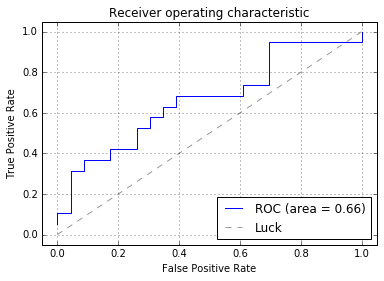

In [30]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

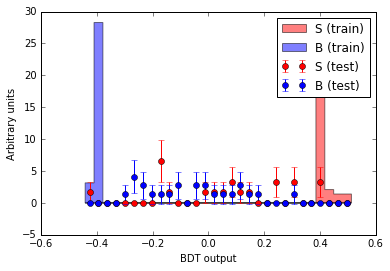

In [31]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='S (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='B (train)')

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)